In [1]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
from moviepy.editor import VideoFileClip


success


In [2]:
def visualize_images(list_imgs):
    
    #list_imgs = list of index of images to be visualized
    _, ax = plt.subplots( len(list_imgs), 1, figsize=(20,36))
    row = 0  
    for img in list_imgs:
        ax[row].imshow(img)        
        ax[row].axis('off')
        row += 1        
    plt.show()
    
def visualize_images_2D(list_imgs):
    
    #list_imgs = list of index of images to be visualized
    _, ax = plt.subplots( math.ceil(len(list_imgs)/2), 2, figsize=(20,36))
    row, col = 0, 0  
    for img in list_imgs:
        ax[row,col].imshow(img)        
        ax[row,col].axis('off')
        
        col+=1
        
        if col == 2:
            row += 1
            col = 0
    plt.show()
def visualize_images_3D(list_imgs):
    
    #list_imgs = list of index of images to be visualized
    _, ax = plt.subplots( math.ceil(len(list_imgs)/3), 3, figsize=(20,36))
    row, col = 0, 0  
    for img in list_imgs:
        ax[row,col].imshow(img)        
        ax[row,col].axis('off')
        
        col+=1
        
        if col == 3:
            row += 1
            col = 0
    plt.show()

In [3]:
def camera_calibrate(nx,ny):
    objPoints = [] # 3d points
    imgPoints = [] # 2d points
    
    imgList = [] # for visualizing images
    
    #prepare object points. like (0,0,0), (1,0,0), (2,0,0)...(nx-1,ny-1,0)
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Read and make a list of calibration images
    images = glob.glob(".\camera_cal\calibration*.jpg")
    
    for fname in images:    
        img = mpimg.imread(fname) #opens images in BGR format
        
        #convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret is True:
            imgPoints.append(corners)
            objPoints.append(objp) # Same for all the images.
            
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)            
            imgList.append(img)
            
        #else:
        #    print("Failed to Detect corners for image: ",fname)
   
    visualize_images(imgList)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints,imgPoints,gray.shape[::-1],None,None)    
    return mtx, dist

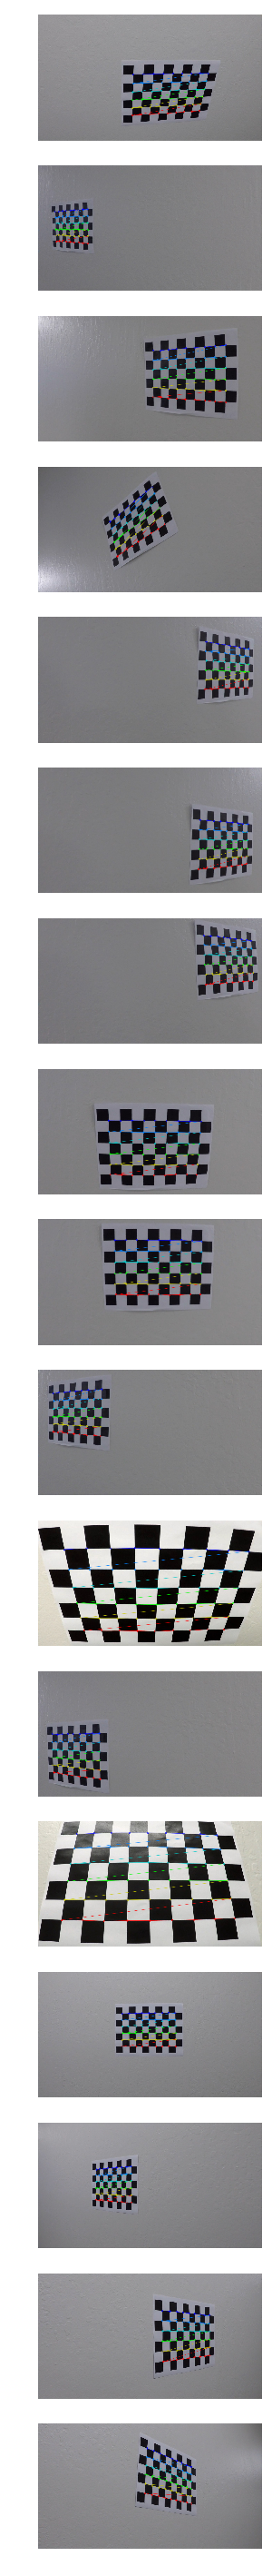

In [4]:
mtx, dist = camera_calibrate(9,6)

In [5]:
def get_perspective_transform_matrix(img):
    
    img_size = img.shape
    uy = np.uint(img_size[0]/1.6) # upper y
    ly = np.uint(img_size[0]) # lower y
    midx = np.uint(img_size[1]/2) # screen middle x
    ulx = midx - .25*np.uint(img_size[1]/2) # upper left x
    urx = midx + .25*np.uint(img_size[1]/2) # upper right x
    llx = midx - 1*np.uint(img_size[1]/2) # lower left x
    lrx = midx + 1*np.uint(img_size[1]/2) # lower right x
    
    src = np.float32([[ulx,uy],[llx,ly],[lrx,ly],[urx,uy]])    
    dst = np.float32([[0,0], [0,img_size[0]], [img_size[1],img_size[0]], [img_size[1],0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    return cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst,src)
     
    
# Change perspective according to matrix M
def corners_unwarp(img, M):        
    
    img_size = img.shape
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)    
    
    return warped


In [6]:

def color_gradient_combo_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S and L channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Apply sobel on L channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Apply a threshold on S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1    
    
    #combine Gradient threshold and Color threshold
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    color_binary = 255 * np.dstack((combined_binary, combined_binary, combined_binary)).astype('uint8')
    return color_binary, combined_binary


In [9]:
def histogram(binary_warped):
    
    global left_fit
    global right_fit
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    return left_fitx, right_fitx



def fit_draw_poly(binary_warped):
    global left_fit
    global right_fit
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(leftx.shape,lefty.shape,rightx.shape,righty.shape,left_fit.shape,right_fit.shape)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))    
    
    return left_fitx, right_fitx

def calculate_carvature(ploty,leftx,rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad
    
def process_frame(img):
    
    global fill
    global detected
    global indx
    global movingAverageLimit
    global matrixGenerated
    global perspectiveMatrix
    global inversePerspectiveMatrix
    
        
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    if matrixGenerated is False:
        perspectiveMatrix, inversePerspectiveMatrix = get_perspective_transform_matrix(dst)
        matrixGenerated = True
    
    warped = corners_unwarp(dst, perspectiveMatrix)
    colorBinary, combined = color_gradient_combo_pipeline(warped.copy())
    
    
    if detected is False:
        left_fitx, right_fitx = histogram(combined)
        detected = True
    else:
        left_fitx, right_fitx = fit_draw_poly(combined)
    leftBuffer[indx] = left_fitx
    rightBuffer[indx] = right_fitx
    
    indx+=1
    
    if indx == movingAverageLimit:
        fill = True
    
    if fill is False:
        left_fitx = np.sum(leftBuffer, axis=0) / indx
        right_fitx = np.sum(rightBuffer, axis=0) / indx
    else:
        left_fitx = np.average(leftBuffer, axis=0)
        right_fitx = np.average(rightBuffer, axis=0)
    
    indx%=movingAverageLimit
    
    warped = colorBinary.copy()
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, inversePerspectiveMatrix, (dst.shape[1], dst.shape[0])) 
    #print(img.shape,dst.shape,warped.shape,warp_zero.shape,newwarp.shape)
    # Combine the result with the original image
    result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)
    
    left_curvature, right_curvature = calculate_carvature(ploty,left_fitx, right_fitx)
    
    curvature_text = 'Left Curvature: {:.2f} m    Right Curvature: {:.2f} m'.format(left_curvature, right_curvature)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, curvature_text, (100, 50), font, 1, (0, 255, 0), 2)
    
    laneCentre = (left_fitx[0] + right_fitx[0])/2
    cameraPosition = abs(laneCentre - result.shape[1]/2) * (3.7/700)
    
    
    cameraPositionText = 'Camera offset: {:.2f} m'.format(cameraPosition)
    cv2.putText(result, cameraPositionText, (100, 90), font, 1, (255, 0, 0), 2)
    
    return result


In [10]:
detected = False
fill = False # determines if the buffer that calculates moving average is filled at least once or not
matrixGenerated = False # determines if the perspective transformation matrix is generated once or not.
indx = 0
movingAverageLimit = 10 # Moving average Number of detected x points on lane lines.
leftBuffer = np.zeros((movingAverageLimit, 720))
rightBuffer = np.zeros((movingAverageLimit, 720))
left_fit, right_fit = np.array([]), np.array([])

perspectiveMatrix, inversePerspectiveMatrix = np.array([]), np.array([])

clip = VideoFileClip('./project_video.mp4')
outClip = clip.fl_image(process_frame)
outClip.write_videofile('./output_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:28<00:00,  8.62it/s]  0%|                                                                                 | 1/1261 [00:00<02:34,  8.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 



In [6]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude         
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1    
    
    # 6) Return this mask as your binary_output image    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_grad = np.arctan2(sobely,sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobel_grad)
    dir_binary[ (sobel_grad >= thresh[0]) & (sobel_grad <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

In [ ]:
# Un distort images
imgList = [] # for visualizing images

# Read and make a list of calibration images
images = glob.glob(".\camera_cal\calibration*.jpg")

for fname in images:    
    img = mpimg.imread(fname) #opens images in BGR format
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    imgList.append(img)
    imgList.append(dst)
visualize_images_2D(imgList)

In [ ]:
# change perspective of undistort images
imgList = [] # for visualizing images

# Read and make a list of calibration images
images = glob.glob(".\images\*")

for fname in images:    
    img = mpimg.imread(fname) #opens images in BGR format
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    M,invM = get_perspective_transform_matrix(dst)
    dst = corners_unwarp(dst,M)
    invdst = corners_unwarp(dst,invM)
    imgList.append(img)
    imgList.append(dst)
    imgList.append(invdst)
print(len(imgList))
visualize_images_3D(imgList)

In [ ]:
# change perspective of undistort images
imgList = [] # for visualizing images

images = glob.glob(".\images\*")

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

for fname in images:    
    image = mpimg.imread(fname) #opens images in BGR format

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    imgList.append(image)
    imgList.append(combined)
    
visualize_images_2D(imgList)

In [ ]:
# Undistort > change perspective > Detect Lane with color and gradient combo
imgList = [] # for visualizing images

# Read and make a list of calibration images
images = glob.glob(".\images\*")

for fname in images:    
    img = mpimg.imread(fname) #opens images in BGR format
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    dst,M = corners_unwarp(dst,9,6,mtx,dist)
    colorBinary, combined = color_gradient_combo_pipeline(dst.copy())
    imgList.append(img)
    imgList.append(dst)
    imgList.append(combined)
#print(len(imgList))
visualize_images_3D(imgList)

In [ ]:
# change perspective of undistort images
imgList = [] # for visualizing images

images = glob.glob(".\images\*")

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

for fname in images:    
    image = mpimg.imread(fname) #opens images in BGR format

    colorBinary, combined = color_gradient_combo_pipeline(image.copy())
    imgList.append(image)
    imgList.append(colorBinary)
    imgList.append(combined)
    
visualize_images_3D(imgList)


In [ ]:
'''
# Read and make a list of calibration images
images = glob.glob(".\images\*")
left_fit, right_fit = np.array([]), np.array([])
for fname in images:    
    img = mpimg.imread(fname) #opens images in BGR format
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    dst,M = corners_unwarp(dst,9,6,mtx,dist)
    colorBinary, combined = color_gradient_combo_pipeline(dst.copy())
    left_fit, right_fit = histogram(combined)
    break
    '''

In [ ]:
'''# Read and make a list of calibration images
images = glob.glob(".\images\*")
for i,fname in enumerate(images):
    if(i < 0):
        continue
    img = mpimg.imread(fname) #opens images in BGR format
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    dst,M = corners_unwarp(dst,9,6,mtx,dist)
    colorBinary, combined = color_gradient_combo_pipeline(dst.copy())
    left_fit, right_fit = fit_draw_poly(combined)
    break'''